---
layout: post
title: Spherical Harmonics
---

In [74]:
from pathlib import Path
import os

from IPython.display import HTML, Image
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from tqdm import tqdm
from celluloid import Camera

ROOT = Path("./assets/img/")

if not os.path.exists(ROOT):
    os.makedirs(ROOT)

Fourier basis are orthonormal basis on the circle:

$$
\{\frac{1}{\sqrt{2 \pi}}\} \cup \{\sqrt{\frac{1}{\pi}} \cos(m\phi), \sqrt{\frac{1}{\pi}} \sin(m\phi): m = 1,2,3,...\}
$$

And a function defined on the circle can be represented as:

$$
f(\phi) = \frac{a_0}{\sqrt{2\pi}} + \sum_{m=1}^\infty [a_m \sqrt{\frac{1}{\pi}} \cos(m\phi) + b_m \sqrt{\frac{1}{\pi}} \sin(m\phi)]
$$

Some Fourier basis

In [29]:
def to_xy(r, phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x, y

In [46]:
def fourier_basis(m, phi, a=1, b=1):
    if m == 0:
        r = (a+b)/2.*1/np.sqrt(2*np.pi)
    else:
        r = np.sqrt(1/np.pi)*(a*np.cos(m*phi) + b*np.sin(m*phi))
    return r

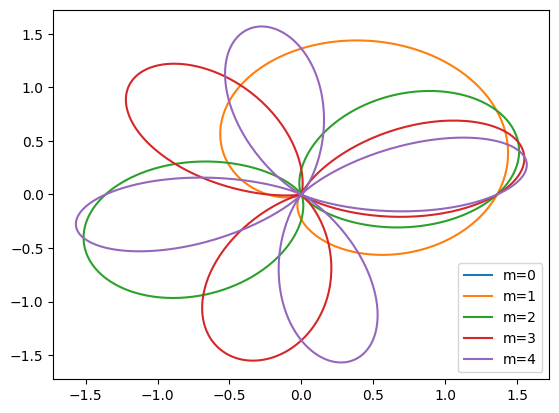

In [60]:
def fourier_basis_plot():

    fig, ax = plt.subplots(1, 1)

    phi_arr = np.linspace(0, 2*np.pi, 500)
    
    for m in np.arange(0, 5):
        
        points = []
        for phi in phi_arr:

            r = fourier_basis(m, phi=phi)
            points.append([r, phi])
        
        points = np.array(points)

        R = -points[:,0].min()
        points[:,0] = R + points[:,0]

        points = np.array([to_xy(r, phi) for r, phi in points])

        ax.plot(points[:,0], points[:,1], label=f"m={m}")

    ax.legend()
    plt.close()
    
    return fig
    
fourier_basis_plot()

Let's sample points in 2D and try to fit using Fourier bases.

In [41]:
def two_d_dataset():
    N = 10
    
    rng = np.random.default_rng(seed=0)
    x = rng.random(N)
    y = rng.random(N)

    return np.array(list(zip(x, y)))

In [42]:
ds_2d = two_d_dataset()

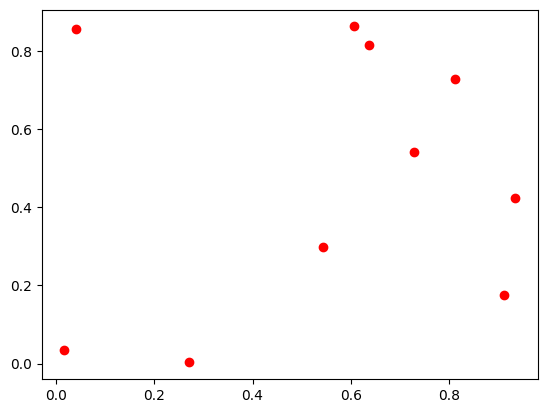

In [45]:
def two_d_dataset_plot():

    fig, ax = plt.subplots(1, 1)

    ax.scatter(ds_2d[:,0], ds_2d[:,1], color="red")

    plt.close()
    return fig
two_d_dataset_plot()

In [79]:
def predict_2d(w, M, phi):
    
    r = 0.
    for m in range(0, M):
        a, b = w[m*2], w[m*2+1]
        r += fourier_basis(m, phi, a=a, b=b)

    return jnp.abs(r)

def loss_2d(w, M, r, phi):

    r_hat = predict_2d(w, M, phi)
    return (r_hat - r)**2


def fit_2d():

    M = 20

    rng = np.random.default_rng(seed=0)
    w = jnp.array(rng.random(2*M))

    fig, ax = plt.subplots(1, 1)
    camera = Camera(fig)
    
    phi_arr = np.linspace(0, 2*np.pi, 200)
    
    def plot():

        ax.scatter(ds_2d[:, 0], ds_2d[:, 1], color="red")

        points = []
        for phi in phi_arr:
            r = predict_2d(w, M, phi)

            points.append([r, phi])

        points = np.array([to_xy(r, phi) for r, phi in points])

        ax.plot(points[:,0], points[:,1], color="royalblue")

        camera.snap()

    plot()
    
    loss_grad = jax.grad(loss_2d, argnums=0)

    epochs = 200
    lr = 0.01

    for _ in tqdm(range(epochs)):
        # g = 0.
        for x, y in ds_2d:
    
            r = np.sqrt(x**2 + y**2)
            phi = np.atan2(y, x) + np.pi
            
            g = loss_grad(w, M, r, phi)
    
            w -= lr*g

        plot()
        
    anim = camera.animate()
    plt.close()

    gif_path = ROOT / "fit_2d.gif"  
    anim.save(gif_path, writer="pillow", fps=30)
    return Image(url=gif_path)

fit_2d()    

100%|██████████| 200/200 [04:52<00:00,  1.46s/it]
